In [1]:
import shutil
import os
os.environ['NOTEBOOK_MODE'] = '1'
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
#from robustness.tools.constants import CLASS_DICT
#from user_constants import DATA_PATH_DICT
from dataset_wrapper import wrapper

In [ ]:
%matplotlib inline

In [2]:
device = ch.device('cuda:0')

=> loading checkpoint './model/svhn/mobilenet/attacker_cnn.pt'
=> loaded checkpoint './model/svhn/mobilenet/attacker_cnn.pt' (epoch 3000)


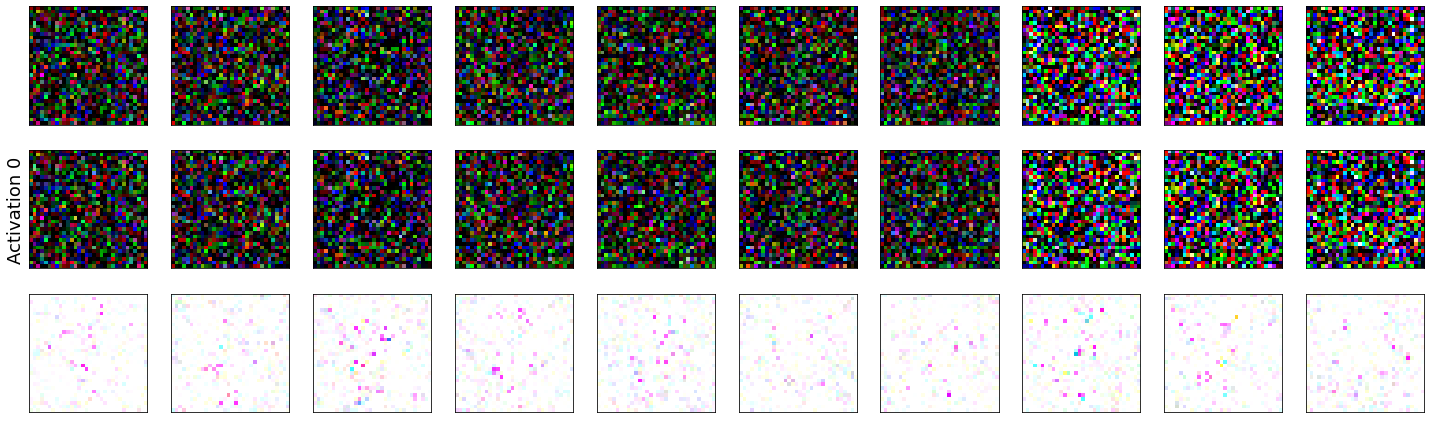

tensor([[ -4.5043,  -3.9707,  14.8239,  -8.9708,  -5.0624,  -7.5751,  -7.6154,
          -7.0756,  -5.8721,  -2.7454],
        [-10.9828,  -3.0839,  -2.9947,  -0.6397,  -5.5881,  12.4210,  -3.2518,
          -4.9483,  -4.8232,  -2.2366],
        [ -7.2490,  -2.1414,  18.0331,  -2.1167,  -5.7252,  -9.8967, -13.1709,
          -8.3425,  -7.3929,  -6.3081],
        [ -3.5178,  -2.9235,  14.1726,  -4.7177,  -8.2097,  -8.1759,  -9.9723,
          -7.8725,  -6.0402,  -2.0970],
        [ -4.8415,  -2.6335,  14.8236,  -4.1236,  -7.9809,  -7.3449,  -9.1655,
          -8.6150,  -5.4154,  -3.9665],
        [ -7.3673,   0.2490,   0.0249,   2.9972,   7.1289,  -6.6124, -11.5513,
          -5.4979,  -8.2270,  -4.5733],
        [ -5.3697,  -2.0497,  11.7847,  -4.5360,  -7.8605,  -5.3487,  -6.0436,
          -7.4633,  -3.8092,  -3.5378],
        [ -3.8231,  -2.0163,  13.5089,  -4.6617,  -7.6141,  -7.9846,  -9.0631,
         -10.4172,  -4.6678,  -2.3477],
        [ -3.8710,  -2.2315,  10.8281,  -1.5096,

In [4]:

#model name
model = 'attacker_cnn'

#read data
#If you want to use other imgs instead of the given samples, then do not comment the following line out
#ds = wrapper()
%matplotlib inline


# Load model

model_kwargs = {
    'arch': 'resnet50',
    'dataset': datasets.CIFAR("cifar10"),
    'resume_path': f'./model/svhn/mobilenet/attacker_cnn.pt',
    'parallel': False
}

model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

# Custom loss to maximize activation
def activation_loss(mod, inp, targ):
    #_, rep = mod(inp, with_latent=True, fake_relu=True)
    _, rep = mod(inp, with_latent=True)
    return rep, None

#If you want to use other imgs instead of the given samples, then use choice1
#choice1: clean validation input
# x_batch, y_batch = ds.eval_data.get_next_batch(10,
#                                                          multiple_passes=True)
# x_batch = x_batch / 255.0
# im = ch.from_numpy(x_batch.astype(np.float32).transpose((0, 3, 1, 2))).cuda()


#choice2: using the given img samples
#im = ch.load('cifarimg.pt')

#If you want to use noise inputs instead of the given samples, then use choice3
#If you use noise inputs, please comment out the related lines in vis_tool.py for better visualization
#choice3: using random noise input (together with choice 1)
im = ch.load('cifar10noise.pt')
#im = ch.load('tiny_im.pt')
im = im.to(device = device)


for i in range(3,4):
    # PGD Parameters
    kwargs = {
            'criterion': ch.nn.CrossEntropyLoss(),
            'custom_loss': activation_loss,
            'constraint':'inf',
            'eps': 1,
            'step_size': 0.1,
            'iterations': 1000, 
            'targeted': False,
            'gamma':0.000001*(10**i)
    }
    # Add features to seed images

#recovered images
    #outputs, im_feat = model(im, 0, make_adv=True, fake_relu=True, **kwargs)
    outputs, im_feat = model(im, 0, make_adv=True, **kwargs)
    show_image_row([im_feat.detach().cpu()], [f'Activation {0}'], fontsize=18, baseline=[im.cpu()])
    _, predicted = outputs.max(1)
    #print out the logits of the recovered images
    print(outputs)
    output_rec = outputs
    

#seed images    
    outputs, im_feat = model(im, 0, make_adv=False, **kwargs)
    _, predicted = outputs.max(1)
    #print out the logits of the original images
    print(outputs)
    output_ori = outputs
    
    log_increase = ch.mean(output_rec - output_ori, 0)
    print(log_increase)
    
    
    #check whether the model is a Trojan model and the target label
    T = 100 #a preset threshold
    target = -1
    for i in range(10):
        if log_increase[i] > T:
            print('The model is a Trojan model and the target label is: {}'.format(i))
            target = i
    if target == -1:
        print('The model is a clean model')